# Final Plotting Notebook

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
from matplotlib.pylab import rc
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

import numpy as np
from scipy.interpolate import griddata

import sys
sys.path.append("../")
from alplib.constants import *
from flux_config import *

mndat_MC_500GeV_2param = np.genfromtxt("multinest/QuestV2/sqrts-500GeV_MC_2param_.txt")
mndat_MC_3TeV_2param = np.genfromtxt("multinest/QuestV2/sqrts-3TeV_MC_2param_.txt")
mndat_MC_10TeV_2param = np.genfromtxt("multinest/QuestV2/sqrts-10TeV_MC_2param_.txt")

mndat_SR_500GeV_2param = np.genfromtxt("multinest/QuestV2/sqrts-500GeV_SR_PLUS_2param_.txt")
mndat_SR_3TeV_2param = np.genfromtxt("multinest/QuestV2/sqrts-3TeV_SR_PLUS_2param_.txt")
mndat_SR_10TeV_2param = np.genfromtxt("multinest/QuestV2/sqrts-10TeV_SR_PLUS_2param_.txt")

mndat_MC_500GeV_gnu = np.genfromtxt("multinest/QuestV2/sqrts-500GeV_MC_nuflavor_.txt")
mndat_MC_3TeV_gnu = np.genfromtxt("multinest/QuestV2/sqrts-3TeV_MC_nuflavor_.txt")
mndat_MC_10TeV_gnu = np.genfromtxt("multinest/QuestV2/sqrts-10TeV_MC_nuflavor_.txt")

mndat_SR_500GeV_gnu = np.genfromtxt("multinest/QuestV2/sqrts-500GeV_SR_PLUS_nuflavor_.txt")
mndat_SR_3TeV_gnu = np.genfromtxt("multinest/QuestV2/sqrts-3TeV_SR_PLUS_nuflavor_.txt")
mndat_SR_10TeV_gnu = np.genfromtxt("multinest/QuestV2/sqrts-10TeV_SR_PLUS_nuflavor_.txt")

# import existing limits
charm2_gv_ga = np.genfromtxt("limits/CHARM2_p1.txt")
texono_gv_ga = np.genfromtxt("limits/TEXONO_zoomed.txt")
lsnd_gv_ga = np.genfromtxt("limits/LSND_zoomed.txt")
e734_ga_gv = np.genfromtxt("limits/BNL_E734.txt")
e734_ga_gv_caddedu = np.genfromtxt("limits/BNL_E734_caddedu_gA_vs_gV.txt")

# WMA
#wma_mn_data = np.genfromtxt("multinest/QuestV2/10TeV_MC_SSW2param_Qfix_.txt")
#wma_mn_data_3TeV = np.genfromtxt("multinest/QuestV2/3TeV_MC_SSW2param_Qfix_.txt")
#wma_mn_data_500GeV = np.genfromtxt("multinest/QuestV2/500GeV_MC_SSW2param_Qfix_.txt")

wma_mn_data = np.genfromtxt("multinest/QuestV2/10TeV_MC_SSW2paramV2_.txt")
wma_mn_data_3TeV = np.genfromtxt("multinest/QuestV2/3TeV_MC_SSW2paramV2_.txt")
wma_mn_data_500GeV = np.genfromtxt("multinest/QuestV2/500GeV_MC_SSW2paramV2_.txt")

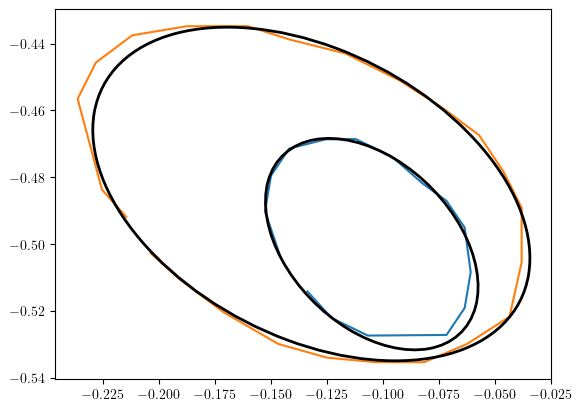

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='auto')

plt.plot(e734_ga_gv[:,1], e734_ga_gv[:,0])
plt.plot(e734_ga_gv_caddedu[:,1], e734_ga_gv_caddedu[:,0])

e1 = Ellipse((-0.132, -0.485), 0.20, 0.09,
                     angle=-14.0, linewidth=2, fill=False, zorder=2)
ax.add_patch(e1)

e2 = Ellipse((-0.105, -0.5), 0.1, 0.055,
                     angle=-22.0, linewidth=2, fill=False, zorder=2)
ax.add_patch(e2)
plt.show()

## Weak Mixing angle Sensitivity: $\sin^2\theta_W = a + b (q - q_0)$ Hypothesis

In [2]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):

    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def plot_WMA_nfile(mndat_list, xlim=(0.235, 0.237), ylim=(-1.5e-3,1.5e-3), scatter=False, n_std=3.0,
                   label_text=None, save_name=None, colors = ['mediumseagreen', 'gold', 'lightsteelblue']):

    # Begin plotting: Two quadrants
    fig, axes = plt.subplots(1, 1, figsize=(8, 6))

    alpha_el = 1.0
    zorder_el = 1
    for i, mndat in enumerate(mndat_list):
        if i == 2:
            alpha_el=0.4
            zorder_el = 0

        a = mndat[:, 2]
        b = 1e3*mndat[:, 3]
        pvals = np.cumsum(mndat[:,0])

        a_90cl = a[pvals > 0.05]
        b_90cl = b[pvals > 0.05]
        a_68cl = a[pvals > 0.32]
        b_68cl = b[pvals > 0.32]
        a_99cl = a[pvals > 0.01]
        b_99cl = b[pvals > 0.01]

        axes.set_ylabel(r"$b$ [GeV$^{-1}$]", fontsize=16)
        axes.set_xlabel(r"$a$", fontsize=16)

        custom_xticks = np.arange(xlim[0], xlim[-1]+0.0005, 0.0005)
        axes.set_xticks(custom_xticks)

        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)

        
        # Calculate a, b variance and mean
        a_68_mean = np.mean(a_68cl)
        b_68_mean = np.mean(b_68cl)
        if label_text is not None:
            if i == 2:
                plt.text(a_68_mean-0.0002, 0.0005, label_text[i], zorder=9, fontsize=14)
            else:
                plt.text(a_68_mean-0.0002, b_68_mean, label_text[i], zorder=9, fontsize=14)

        confidence_ellipse(a_68cl, b_68cl, axes, n_std=n_std, edgecolor=colors[i], facecolor=colors[i], alpha=alpha_el, zorder=zorder_el)
        confidence_ellipse(a_90cl, b_90cl, axes, n_std=1.1*n_std, edgecolor=colors[i], ls='dashed')
        confidence_ellipse(a_99cl, b_99cl, axes, n_std=1.2*n_std, edgecolor=colors[i], ls='dotted')

        if scatter:
            plt.scatter(a_99cl, b_99cl, color='silver', marker=".", alpha=0.5)
            plt.scatter(a_90cl, b_90cl, color='khaki', marker=".", alpha=0.5)
            plt.scatter(a_68cl, b_68cl, color='mediumseagreen', marker=".", alpha=0.2)


    # Set the grids
    axes.grid(True, linestyle='-', linewidth=0.5, alpha=0.6, color='gray', dashes=(5,10))

    for line in plt.gca().xaxis.get_gridlines():
        line.set_dash_capstyle('round')

    for line in plt.gca().yaxis.get_gridlines():
        line.set_dash_capstyle('round')
    
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)

    plt.hlines(y=0.0, xmin=xlim[0], xmax=xlim[-1], color='k', linewidth=1.0)
    #plt.text(0.2356, 0.00015, "No Running", fontsize=14)

    plt.title(r"$\sin^2\theta_W(Q) = a + b (Q - Q_0)$ Hypothesis", loc="right", fontsize=16)

    return fig, axes

    

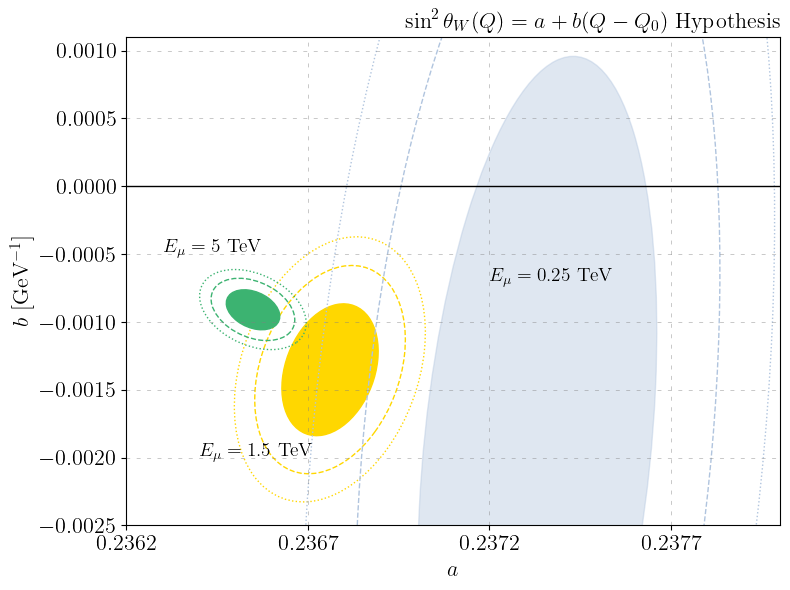

In [3]:

fig, axes = plot_WMA_nfile([wma_mn_data_3TeV, wma_mn_data, wma_mn_data_500GeV], xlim=(0.2362, 0.2380), ylim=(-0.0025, 0.0011),
               n_std=2.4, label_text=None,
               colors=['gold', 'mediumseagreen', 'lightsteelblue'],
               scatter=False, save_name="plots/weak_mixing/wma_a_vs_b_3benchmark.pdf")


plt.tight_layout()

label_text = [r"$\sqrt{s} = 3$ TeV MC", r"$\sqrt{s} = 10$ TeV MC", r"$\sqrt{s} = 500$ GeV MC"]

plt.text(0.2372, -0.0007, r"$E_\mu = 0.25$ TeV", zorder=9, fontsize=14)
plt.text(0.2364, -0.00199, r"$E_\mu = 1.5$ TeV", zorder=9, fontsize=14)
plt.text(0.2363, -0.00049, r"$E_\mu = 5$ TeV", zorder=9, fontsize=14)

fig.savefig("plots/weak_mixing/wma_a_vs_b_3benchmark.pdf")

plt.show()
plt.close()

## gV - gA

In [41]:
# Curtail the existing bounds
charm2_gV = np.append(charm2_gv_ga[:,0], charm2_gv_ga[0,0])
charm2_gA = np.append(charm2_gv_ga[:,1], charm2_gv_ga[0,1])



lsnd_line_lower = np.array([[-0.002640000000000031, -0.6016986706056132],
                            [-0.16872, -0.39874446085672083]])
lsnd_line_upper = np.array([[-0.005519999999999969, -0.3981536189069425],
                            [0.12648000000000004, -0.5650664697193503]])


tex_line_lower = np.array([[-0.13704, -0.6014032496307239],
                            [0.028560000000000085, -0.39933530280649937]])
tex_line_upper = np.array([[-0.016559999999999964, -0.6016986706056131],
                            [0.12552000000000008, -0.39785819793205335]])




def plot_gVgA_2param_MC_SR(mndat_list_mc, mndat_list_sr, slist, marker_list=["*", "+", "x"],
                        color_list=['royalblue', 'goldenrod', 'mediumseagreen'],
                        plot_title=r"$\mu^+ \mu^-$ Collider",
                        label_list=[r"$\sqrt{s} = 500$ GeV", r"$\sqrt{s} = 3$ TeV", r"$\sqrt{s} = 10$ TeV"],
                        save_name=None):

    # Begin plotting: Two quadrants
    fig, axes = plt.subplots(figsize=(10, 6))
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    handles, labels = plt.gca().get_legend_handles_labels()

    # Create the inset
    ax_inset = fig.add_axes([0.23, 0.21, 0.3, 0.35])  # [left, bottom, width, height]
    ax_inset_gV_range = [-0.029, -0.022]
    ax_inset_gA_range = [-0.51, -0.49]

    def plot_contours(mndat_list, ls="solid"):
        for i, mndat in enumerate(mndat_list):
            # Read in data
            g_L = mndat[:, 2]
            g_R = mndat[:, 3]
            deltaChi2 = 8*mndat[:, 1]

            # Assign colors and alphas based on different contours
            colors = np.zeros_like(deltaChi2, dtype=object)
            colors[deltaChi2 < 2.3] = 'navy'
            colors[(deltaChi2 >= 2.3) & (deltaChi2 < 6.18)] = 'mediumseagreen'
            colors[deltaChi2 >= 6.18] = 'silver'

            alphas = np.zeros_like(deltaChi2, dtype=object)
            alphas[deltaChi2 < 2.3] = 0.5
            alphas[(deltaChi2 >= 2.3) & (deltaChi2 < 6.18)]  = 0.9
            alphas[deltaChi2 >= 6.18] = 0.0

            gV = (g_L + g_R)
            gA = (g_L - g_R)

            # SM point
            ax_inset.plot(-0.5 + 2*fluxes_dict[slist[i]]["SSW_MUP"], -0.5,
                        color=color_list[i], marker=marker_list[i])
            
            # Try with grid interp only in the specified range
            grid_x, grid_y = np.mgrid[ax_inset_gV_range[0]:ax_inset_gV_range[1]:5000j,
                                      ax_inset_gA_range[0]:ax_inset_gA_range[1]:5000j]
            grid_deltaChi2 = griddata((gV, gA), deltaChi2, (grid_x, grid_y), method='cubic')
            axes.contour(grid_x, grid_y, grid_deltaChi2, levels=[4.61], colors=color_list[i], linestyles=ls, linewidths=1.0)
            ax_inset.contour(grid_x, grid_y, grid_deltaChi2, levels=[4.61], colors=color_list[i], linestyles=ls, linewidths=1.0)

    # Plot the Muon Ring and Collider contours
    plot_contours(mndat_list_mc, ls='solid')
    plot_contours(mndat_list_sr, ls='dotted')
    
    # Legends
    for i in range(len(label_list)):
        line = Line2D([0], [0], label=label_list[i], color=color_list[i])
        handles.extend([line])

    # plot the existing bounds
    #axes.plot(charm2_gV, charm2_gA, color="dimgray", linewidth=1.0)
    axes.plot(lsnd_line_lower[:,0], lsnd_line_lower[:,1], color='sienna', linewidth=1.0)
    axes.plot(lsnd_line_upper[:,0], lsnd_line_upper[:,1], color='sienna', linewidth=1.0)
    axes.plot(tex_line_lower[:,0], tex_line_lower[:,1], color='mediumpurple', linewidth=1.0)
    axes.plot(tex_line_upper[:,0], tex_line_upper[:,1], color='mediumpurple', linewidth=1.0)

    # E734
    #e1 = Ellipse((-0.102, -0.503), 0.048, 0.037,
    #                 angle=-14.0, linewidth=1.0, color='turquoise', fill=False)
    #axes.add_patch(e1)

    # labels
    axes.text(-0.135, -0.45, "LSND", rotation=-51.0, fontsize=16, color='sienna')
    axes.text(-0.03, -0.46, "TEXONO", rotation=51.5, fontsize=16, color='mediumpurple')
    axes.text(0.00, -0.48, "CHARM-II", fontsize=16, color='dimgray')
    e1 = Ellipse((-0.035, -0.502), 0.0775, 0.0775,
                     angle=0.0, linewidth=1.0, color='dimgray', fill=False)
    axes.add_patch(e1)

    ax_inset.plot([-0.0285, -0.0275], [-0.504, -0.504], 'k-', linewidth=1)  # Solid line marker
    ax_inset.plot([-0.0285, -0.0275], [-0.507, -0.507], 'k:', linewidth=1)  # Dashed line marker

    # Add text next to the drawn lines
    ax_inset.text(-0.027, -0.504, r"$\mu^+ \mu^-$ MC", fontsize=12, verticalalignment='center')
    ax_inset.text(-0.027, -0.507, r"$\mu^+$ SR", fontsize=12, verticalalignment='center')

    axes.tick_params(axis="x", labelsize=16)
    axes.tick_params(axis="y", labelsize=16)
    axes.tick_params(axis="x", labelsize=16)
    axes.tick_params(axis="y", labelsize=16)
    ax_inset.tick_params(axis="x", labelsize=14)
    ax_inset.tick_params(axis="y", labelsize=14)
    ax_inset.tick_params(axis="x", labelsize=14)
    ax_inset.tick_params(axis="y", labelsize=14)

    ax_inset.set_xlim(ax_inset_gV_range)
    ax_inset.set_ylim(ax_inset_gA_range)
    ax_inset.set_xlabel(r"$g_V$", fontsize=16)
    ax_inset.set_ylabel(r"$g_A$", fontsize=16)

    axes.set_xlim((-0.2, 0.04))
    axes.set_ylim((-0.55, -0.42))
    axes.set_xlabel(r"$g_V$", fontsize=16)
    axes.set_ylabel(r"$g_A$", fontsize=16)

    # Set the grids
    axes.grid(True, linestyle='-', linewidth=0.5, alpha=0.6, color='gray', dashes=(5,10))
    ax_inset.grid(True, linestyle='-', linewidth=0.5, alpha=0.6, color='gray', dashes=(5,10))

    for line in plt.gca().xaxis.get_gridlines():
        line.set_dash_capstyle('round')

    for line in plt.gca().yaxis.get_gridlines():
        line.set_dash_capstyle('round')


    axes.legend(handles=handles, loc="upper left", framealpha=1, fontsize=14)

    
    plt.show()
    plt.tight_layout()
    if save_name is not None:
        fig.savefig(save_name)
    plt.close()


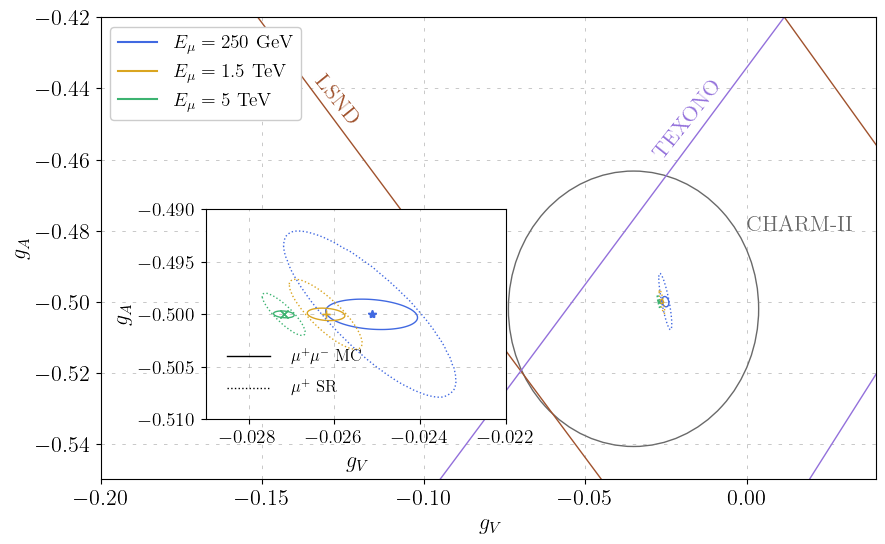

In [42]:
plot_gVgA_2param_MC_SR(mndat_list_sr=[mndat_SR_500GeV_2param,
                                mndat_SR_3TeV_2param,
                                mndat_SR_10TeV_2param],
                        mndat_list_mc=[mndat_MC_500GeV_2param,
                                mndat_MC_3TeV_2param,
                                mndat_MC_10TeV_2param],
                  slist=["500GeV", "3TeV", "10TeV"], plot_title=r"$\mu^-$ Storage Ring",
                  label_list=[r"$E_\mu = 250$ GeV", r"$E_\mu = 1.5$ TeV", r"$E_\mu = 5$ TeV"],
                  save_name="plots/VA_couplings/gV_gA_MC_SR_with_extLimits_v2.pdf")

## Flavored couplings and Charge Radii

In [49]:
def plot_gnu_2param(mc_dat_list, sr_dat_list, slist, marker_list=["*", "+", "x"],
                        color_list=['royalblue', 'orange', 'mediumseagreen'],
                        plot_points=False, plot_title=r"$\mu^+ \mu^-$ Collider",
                        label_list=[r"$\sqrt{s} = 500$ GeV", r"$\sqrt{s} = 3$ TeV", r"$\sqrt{s} = 10$ TeV"],
                        save_name="plots/VA_couplings/gV_gA_MC_benchmark_sensitivity.pdf"):

    # Begin plotting: Two quadrants
    fig, axes = plt.subplots(figsize=(8, 8))
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    handles, labels = plt.gca().get_legend_handles_labels()

    for i, mndat in enumerate(sr_dat_list):
        # Read in data
        gnu_e = mndat[:, 2]
        gnu_mu = mndat[:, 3]
        deltaChi2 = 8*mndat[:, 1]

        # Assign colors and alphas based on different contours
        colors = np.zeros_like(deltaChi2, dtype=object)
        colors[deltaChi2 < 2.3] = 'navy'
        colors[(deltaChi2 >= 2.3) & (deltaChi2 < 6.18)] = 'mediumseagreen'
        colors[deltaChi2 >= 6.18] = 'silver'

        alphas = np.zeros_like(deltaChi2, dtype=object)
        alphas[deltaChi2 < 2.3] = 0.5
        alphas[(deltaChi2 >= 2.3) & (deltaChi2 < 6.18)]  = 0.9
        alphas[deltaChi2 >= 6.18] = 0.0

        if plot_points:
            axes.scatter(gnu_e, gnu_mu, c=colors, alpha=alphas, cmap='viridis', s=1)

        # Try with grid interp
        grid_x, grid_y = np.mgrid[min(gnu_e):max(gnu_e):5000j, min(gnu_mu):max(gnu_mu):5000j]
        grid_deltaChi2 = griddata((gnu_e, gnu_mu), deltaChi2, (grid_x, grid_y), method='cubic')
        axes.contour(grid_x, grid_y, grid_deltaChi2, levels=[4.61], colors=color_list[i], linestyles='dotted')

        if plot_points:    
            axes.scatter(gnu_e, gnu_mu, c=colors, alpha=alphas, cmap='viridis', s=1)
        
        #line = Line2D([0], [0], label=label_list[i], color=color_list[i])
        #handles.extend([line])
    
    for i, mndat in enumerate(mc_dat_list):
        # Read in data
        gnu_e = mndat[:, 2]
        gnu_mu = mndat[:, 3]
        deltaChi2 = 8*mndat[:, 1]

        # Assign colors and alphas based on different contours
        colors = np.zeros_like(deltaChi2, dtype=object)
        colors[deltaChi2 < 2.3] = 'navy'
        colors[(deltaChi2 >= 2.3) & (deltaChi2 < 6.18)] = 'mediumseagreen'
        colors[deltaChi2 >= 6.18] = 'silver'

        alphas = np.zeros_like(deltaChi2, dtype=object)
        alphas[deltaChi2 < 2.3] = 0.5
        alphas[(deltaChi2 >= 2.3) & (deltaChi2 < 6.18)]  = 0.9
        alphas[deltaChi2 >= 6.18] = 0.0

        if plot_points:
            axes.scatter(gnu_e, gnu_mu, c=colors, alpha=alphas, cmap='viridis', s=1)

        # Try with grid interp
        grid_x, grid_y = np.mgrid[min(gnu_e):max(gnu_e):5000j, min(gnu_mu):max(gnu_mu):5000j]
        grid_deltaChi2 = griddata((gnu_e, gnu_mu), deltaChi2, (grid_x, grid_y), method='cubic')
        axes.contour(grid_x, grid_y, grid_deltaChi2, levels=[4.61], colors=color_list[i])

        if plot_points:    
            axes.scatter(gnu_e, gnu_mu, c=colors, alpha=alphas, cmap='viridis', s=1)

        line = Line2D([0], [0], label=label_list[i], color=color_list[i])
        handles.extend([line])

    axes.tick_params(axis="x", labelsize=18)
    axes.tick_params(axis="y", labelsize=18)

    axes.plot([0.491, 0.4925], [0.504, 0.504], 'k-', linewidth=1)  # Solid line marker
    axes.plot([0.491, 0.4925], [0.502, 0.502], 'k:', linewidth=1)  # Dashed line marker

    # Add text next to the drawn lines
    axes.text(0.494, 0.504, r"$\mu^+ \mu^-$ MC", fontsize=18, verticalalignment='center')
    axes.text(0.494, 0.502, r"$\mu^+$ SR", fontsize=18, verticalalignment='center')

    axes.set_xlim((0.49, 0.51))
    axes.set_ylim((0.488, 0.512))
    axes.set_ylabel(r"$g_{\nu_\mu}$", fontsize=18)
    axes.set_xlabel(r"$g_{\nu_e}$", fontsize=18)

    # Set the grids
    axes.grid(True, linestyle='-', linewidth=0.5, alpha=0.6, color='gray', dashes=(5,10))

    for line in plt.gca().xaxis.get_gridlines():
        line.set_dash_capstyle('round')

    for line in plt.gca().yaxis.get_gridlines():
        line.set_dash_capstyle('round')

    axes.legend(handles=handles, loc="upper left", framealpha=1, fontsize=14)

    
    plt.show()
    plt.tight_layout()
    if save_name is not None:
        fig.savefig(save_name)
    plt.close()

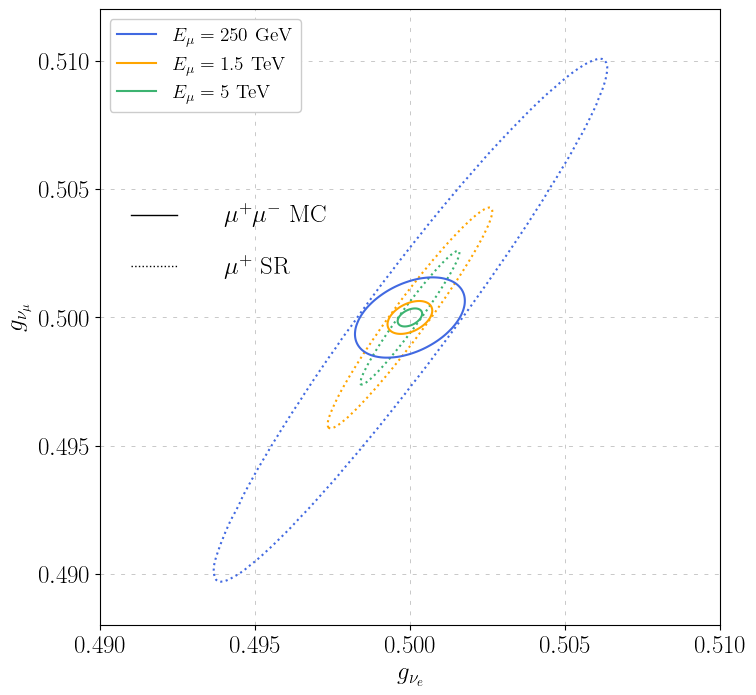

In [50]:
plot_gnu_2param(mc_dat_list=[mndat_MC_500GeV_gnu, mndat_MC_3TeV_gnu, mndat_MC_10TeV_gnu],
                sr_dat_list=[mndat_SR_500GeV_gnu, mndat_SR_3TeV_gnu, mndat_SR_10TeV_gnu],
                  slist=["500GeV", "3TeV", "10TeV"], plot_title=r"",
                  label_list=[r"$E_\mu = 250$ GeV", r"$E_\mu = 1.5$ TeV", r"$E_\mu = 5$ TeV"],
                  save_name="plots/VA_couplings/gnu_MC_SR_benchmark_sensitivity_v2.pdf")

In [53]:
rnu_e_SM = HBARC**2 * G_F * (3 - 2 * np.log(np.power(M_E/M_W, 2))) / (4*sqrt(2)*pi**2)
rnu_mu_SM = HBARC**2 * G_F * (3 - 2 * np.log(np.power(M_MU/M_W, 2))) / (4*sqrt(2)*pi**2)

def plot_charge_radii_2d(mn_dat_list, slist, marker_list=["*", "+", "x"],
                        color_list=['royalblue', 'orange', 'mediumseagreen'],
                        plot_points=False, plot_title=r"$\mu^+ \mu^-$ Collider",
                        label_list=[r"$\sqrt{s} = 500$ GeV", r"$\sqrt{s} = 3$ TeV", r"$\sqrt{s} = 10$ TeV"],
                        save_name="plots/VA_couplings/gV_gA_MC_benchmark_sensitivity.pdf"):

    # Begin plotting: Two quadrants
    fig, axes = plt.subplots(figsize=(8, 8))
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    handles, labels = plt.gca().get_legend_handles_labels()

    for i, mndat in enumerate(mn_dat_list):
        # Read in data
        # We varied 2*norm * g_L, g_R, so the translation to charge radius goes like
        # (g_L + g_R) * (2 * cube - 1) / charge radius prefactor - see notes
        radius_prefactor = (2*M_W**2 * (fluxes_dict[slist[i]]["SSW_MUP"])**2 / 3) / HBARC**2
        gnu_e = 1e32*(2*fluxes_dict[slist[i]]["SSW_MUP"]**2 - 0.5)*(2*mndat[:, 2] - 1)/radius_prefactor
        gnu_mu = 1e32*(2*fluxes_dict[slist[i]]["SSW_MUP"]**2 - 0.5)*(2*mndat[:, 3] - 1)/radius_prefactor
        deltaChi2 = mndat[:, 1]


        # Try with grid interp
        grid_x, grid_y = np.mgrid[min(gnu_e):max(gnu_e):5000j, min(gnu_mu):max(gnu_mu):5000j]
        grid_deltaChi2 = griddata((gnu_e, gnu_mu), deltaChi2, (grid_x, grid_y), method='cubic')
        axes.contour(grid_x, grid_y, grid_deltaChi2, levels=[4.61], colors=color_list[i])
        

        line = Line2D([0], [0], label=label_list[i], color=color_list[i])
        handles.extend([line])
    
    axes.vlines(1e32*rnu_e_SM, ymin=0.0, ymax=1, color='k', linestyle='dotted', linewidth=1.0)
    axes.hlines(1e32*rnu_mu_SM, xmin=0.0, xmax=1, color='k', linestyle='dotted', linewidth=1.0)
    axes.text(1e32*rnu_e_SM+0.02, 0.61, r"$\langle r_{\nu_e}^2 \rangle_{\rm SM}$", fontsize=18, color='k')
    axes.text(0.5, 1e32*rnu_mu_SM+0.02, r"$\langle r_{\nu_\mu}^2 \rangle_{\rm SM}$", fontsize=18, color='k')


    axes.tick_params(axis="x", labelsize=18)
    axes.tick_params(axis="y", labelsize=18)

    axes.set_xlim((0.0, 0.8))
    axes.set_ylim((0.0, 0.8))
    axes.set_ylabel(r"$\langle r_{\nu_\mu}^2 \rangle$ [$10^{-32}$ cm$^2$]", fontsize=18)
    axes.set_xlabel(r"$\langle r_{\nu_e}^2 \rangle$ [$10^{-32}$ cm$^2$]", fontsize=18)
    # Set the grids
    axes.grid(True, linestyle='-', linewidth=0.5, alpha=0.6, color='gray', dashes=(5,10))

    for line in plt.gca().xaxis.get_gridlines():
        line.set_dash_capstyle('round')

    for line in plt.gca().yaxis.get_gridlines():
        line.set_dash_capstyle('round')

    axes.legend(handles=handles, loc="upper right", framealpha=1, fontsize=14)

    
    plt.show()
    plt.tight_layout()
    if save_name is not None:
        fig.savefig(save_name)
    plt.close()

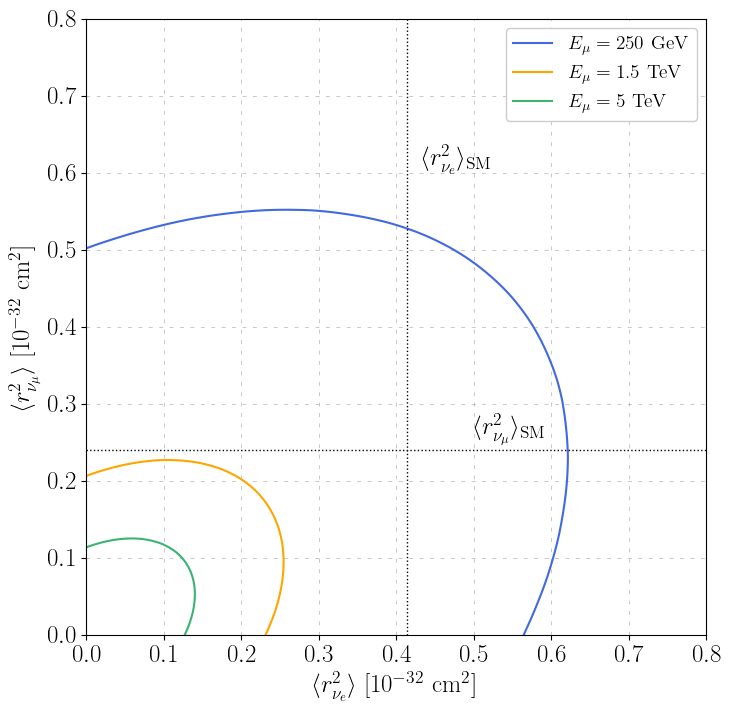

In [54]:
plot_charge_radii_2d(mn_dat_list=[mndat_MC_500GeV_gnu, mndat_MC_3TeV_gnu, mndat_MC_10TeV_gnu],
                  slist=["500GeV", "3TeV", "10TeV"], plot_title=r"", plot_points=True,
                  label_list=[r"$E_\mu = 250$ GeV", r"$E_\mu = 1.5$ TeV", r"$E_\mu = 5$ TeV"],
                  save_name="plots/VA_couplings/charge_radius_MC_benchmark_sensitivity.pdf")

## 4-parameter sensitivity

In [2]:
from scipy.signal import savgol_filter

def cornerplot(samples, deltaChi2, prob, sm_values, labels,
               axes_ranges=[(0.0, 1.0), (0.0, 1.0), (-0.3, 0.3), (0.0, 0.3)],
               save_name=None, nbins=200, savgol_window=20):

    p_sorted_idx = np.argsort(prob)


    # color code
    colors = np.zeros_like(deltaChi2, dtype=object)

    # delta Chi^2 values are based on 4 DOF
    colors[deltaChi2 < 4.71] = 'navy'
    colors[(deltaChi2 >= 4.71) & (deltaChi2 < 9.715)] = 'mediumseagreen'
    colors[deltaChi2 >= 9.715] = 'silver'  # Optional: color values greater than 9.715 red, or keep this line out

    colors2 = np.zeros_like(deltaChi2, dtype=object)
    colors2[deltaChi2 < 4.71] = 'b'
    colors2[(deltaChi2 >= 4.71) & (deltaChi2 < 9.715)] = 'mediumseagreen'
    colors2[deltaChi2 >= 9.715] = 'silver'  # Optional: color values greater than 9.715 red, or keep this line out

    alphas = np.zeros_like(deltaChi2, dtype=object)
    alphas[deltaChi2 < 4.71] = 0.4
    alphas[(deltaChi2 >= 4.71) & (deltaChi2 < 9.715)]  = 0.5
    alphas[deltaChi2 >= 9.715] = 0.8

    # ranges and SM values
    bins = [np.linspace(r[0], r[1], nbins) for r in axes_ranges]


    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    # Loop over pairs of parameters to create the contour plots
    for i in range(4):
        for j in range(4):
            axes[i, j].grid(True, linestyle='-', linewidth=0.5, alpha=0.8, color='gray', dashes=(5,10))
            axes[i, j].tick_params(axis="x", labelsize=16)
            axes[i, j].tick_params(axis="y", labelsize=16)
            for line in plt.gca().xaxis.get_gridlines():
                line.set_dash_capstyle('round')
            for line in plt.gca().yaxis.get_gridlines():
                line.set_dash_capstyle('round')
            
            if i == j:
                # Diagonal: plot the histograms of the individual parameters
                bin_centers = (bins[i][1:] + bins[i][:-1])/2
                hp, _ = np.histogram(samples[:,i], weights=prob, bins=bins[i])

                smoothed_h = savgol_filter(hp, savgol_window, 2)

                h, _ = np.histogram(bin_centers, bins=bins[i], weights=smoothed_h, density=True)
                axes[i, j].plot(bin_centers, h, color='royalblue', alpha=0.7)

                axes[i,j].vlines(x=sm_values[j], ymin=0.0, ymax=1.0, color='firebrick')
                
                # Plotting direct prob curve
                # sorted_indices = np.argsort(samples[:, i])
                # axes[i,j].plot(samples[:, i][sorted_indices], savgol_filter(prob[sorted_indices], 500, 1))
                axes[i,j].set_xlim(axes_ranges[j])
                #axes[i,j].set_xscale('symlog', linthresh=1e-2)
                axes[i,j].set_ylim(bottom=1e-1)
                axes[i,j].set_ylabel(r"Probability Density", fontsize=18)

            elif i > j:
                # Lower triangle: plot contours of constant log-likelihood
                axes[i, j].scatter(samples[:, j][p_sorted_idx], samples[:, i][p_sorted_idx],
                                c=colors[p_sorted_idx], s=1, alpha=alphas, marker='.')
                #axes[i, j].contour(np.histogram2d(samples[:, j], samples[:, i], bins=gLR_bins, weights=deltaChi2)[0], levels=[2.30, 6.18, 11.83, 200.0, 1000.0], colors='white')
                axes[i,j].set_ylim(axes_ranges[i])
                axes[i,j].set_xlim(axes_ranges[j])

                axes[i,j].scatter(sm_values[j], sm_values[i], marker='o', edgecolors='r', s=40.0, facecolors='none')
            else:
                #axes[i,j].plot(sm_values[j], sm_values[i], marker='*', color='r')
                axes[i, j].axis('off')

            # Set parameter labels
            if i == 3:
                axes[i, j].set_xlabel(labels[j], fontsize=18)
            #else:
            #    axes[i, j].set_xticks([])
            if j == 0 and i != j:
                axes[i, j].set_ylabel(labels[i], fontsize=18)

    plt.tight_layout()

    if save_name is not None:
        fig.savefig(save_name)

    plt.show()
    plt.close()


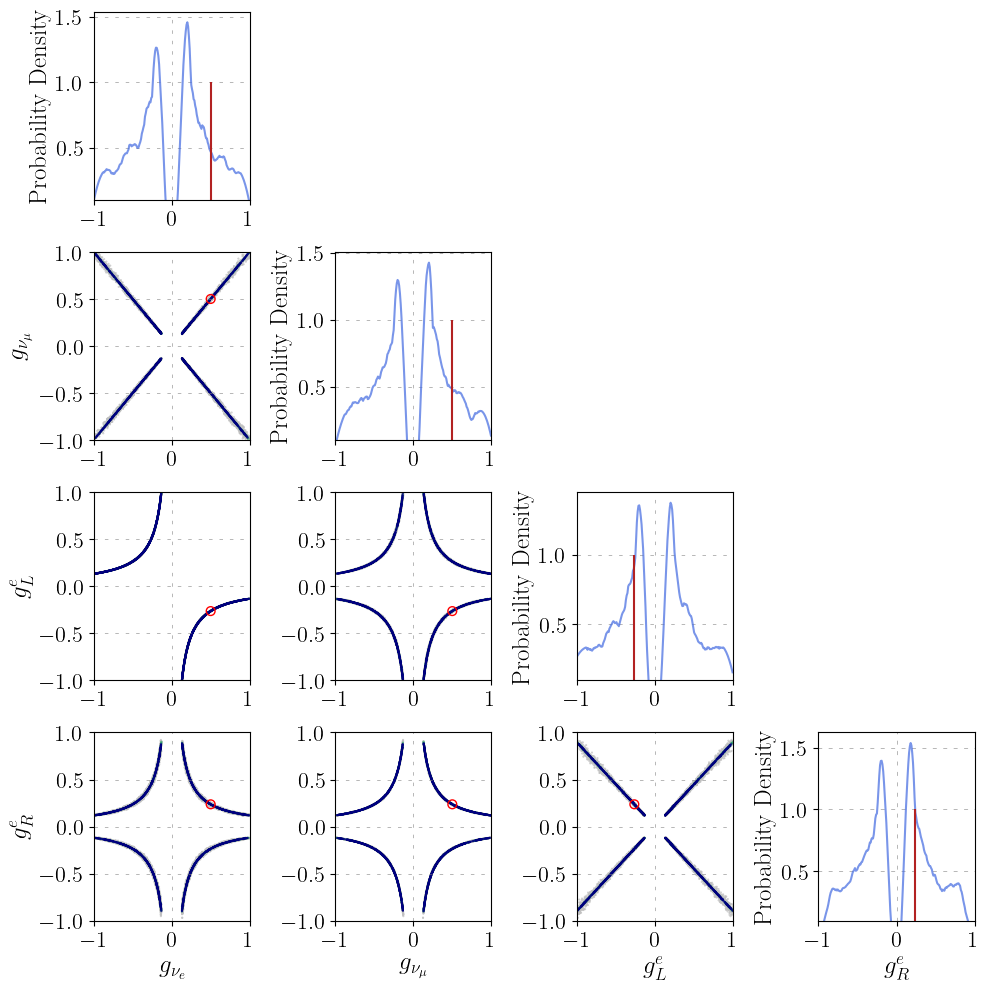

In [7]:
multinest_output = np.genfromtxt("multinest/QuestV2/sqrts-10TeV_MC_.txt")

g_nue = multinest_output[:, 2]
g_numu = multinest_output[:, 3]
g_L = multinest_output[:, 4]
g_R = multinest_output[:, 5]


deltaChi2 = multinest_output[:,1]
prob = multinest_output[:,0]
sm_values = [0.5, 0.5, -0.5 + fluxes_dict["10TeV"]["SSW_MUP"], fluxes_dict["10TeV"]["SSW_MUP"]]

# Combine the parameters into a single array for corner plot
samples = np.vstack([g_nue, g_numu, g_L, g_R]).T

# Define the labels for the parameters
labels = [r"$g_{\nu_e}$", r"$g_{\nu_\mu}$", r"$g_L^e$", r"$g_R^e$"]

axes_ranges = [(-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0)]

cornerplot(samples, deltaChi2, prob, sm_values, labels, axes_ranges, save_name="plots/VA_couplings/10TeV_MC_cornerplot.png", savgol_window=23)
#cornerplot(samples, deltaChi2, prob, sm_values, labels, axes_ranges, save_name=None)

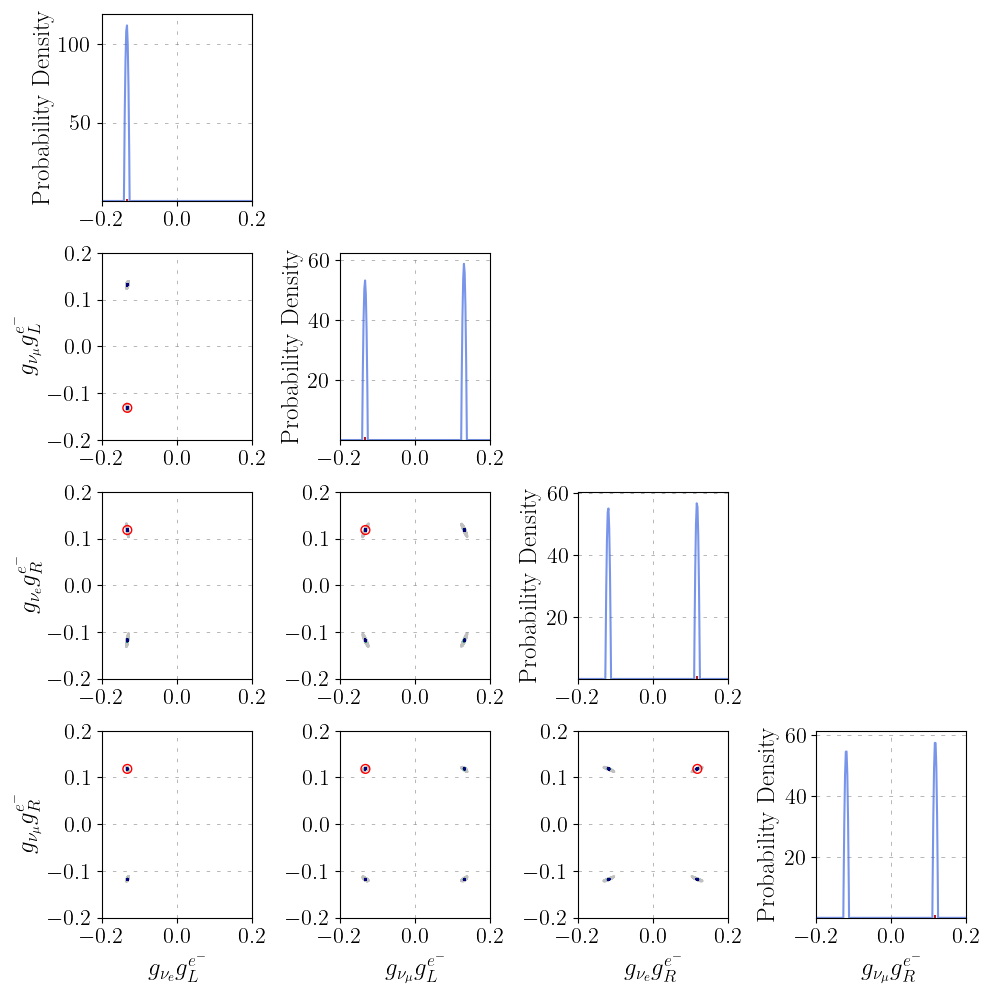

In [32]:
multinest_output = np.genfromtxt("multinest/QuestV2/sqrts-10TeV_MC_.txt")

g_nue = multinest_output[:, 2]
g_numu = multinest_output[:, 3]
g_L = multinest_output[:, 4]
g_R = multinest_output[:, 5]


deltaChi2 = multinest_output[:,1]
prob = multinest_output[:,0]
sm_values = [0.5*(-0.5 + fluxes_dict["10TeV"]["SSW_MUP"]),
             0.5*(-0.5 + fluxes_dict["10TeV"]["SSW_MUP"]),
             0.5*fluxes_dict["10TeV"]["SSW_MUP"],
             0.5*fluxes_dict["10TeV"]["SSW_MUP"]]

# Combine the parameters into a single array for corner plot
samples = np.vstack([g_nue*g_L, g_numu*g_L, g_nue*g_R, g_numu*g_R]).T

# Define the labels for the parameters
labels = [r"$g_{\nu_e} g_L^{e^-}$", r"$g_{\nu_\mu} g_L^{e^-}$", r"$g_{\nu_e} g_R^{e^-}$", r"$g_{\nu_\mu} g_R^{e^-}$"]

axes_ranges = [(-0.2, 0.2), (-0.2, 0.2), (-0.2, 0.2), (-0.2, 0.2)]

#cornerplot(samples, deltaChi2, prob, sm_values, labels, axes_ranges, save_name="plots/VA_couplings/10TeV_MC_cornerplot.png")
cornerplot(samples, deltaChi2, prob, sm_values, labels, axes_ranges,
           save_name="plots/VA_couplings/10TeV_MC_cornerplot_combos.png", nbins=200, savgol_window=10)